As we were not overly thrilled or satisfied with the results of our models predicting ability using R I decided to take a different approach. Not only did I decide to switch from using R to Python but also moved to a Neural Network using TensorFlow. My inspiration to do this is actually from the other class I am taking right now and I saw the opportunity to use some of the knowlege from that class along with this one to attmept to create a better model.

If you want to run the model you must install tensforflow through pip by using the following command

pip install tf

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from tensorflow import keras
from tensorflow.keras import layers

In [4]:
#Read Dataset in
raw_dataset = pd.read_csv("./data/train.csv", na_values = "?")

/home/ashton/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#Verify our dataset and make a copy of the raw
dataset = raw_dataset.copy()
dataset.tail()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
509757,2018123015,20181230154157,home,86.77,24.20,2.14,2.12,0.22,44.55,15.31,2555289,Nick Vannett,81,2018,23,4,00:16:00,SEA,2,8,ARZ,24,24,2558865,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR",9.0,"4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,11,6-6,261,03/06/1993,Ohio State,TE,SEA,ARI,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509758,2018123015,20181230154157,home,86.76,27.18,1.16,0.66,0.11,53.63,42.80,2555395,Germain Ifedi,65,2018,23,4,00:16:00,SEA,2,8,ARZ,24,24,2558865,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR",9.0,"4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,11,6-5,325,06/02/1994,Texas A&M,G,SEA,ARI,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509759,2018123015,20181230154157,home,87.26,27.05,2.59,1.18,0.26,3.96,21.12,2556524,George Fant,74,2018,23,4,00:16:00,SEA,2,8,ARZ,24,24,2558865,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR",9.0,"4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,11,6-5,322,07/19/1992,Western Kentucky,OT,SEA,ARI,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509760,2018123015,20181230154157,home,84.57,24.37,4.36,1.79,0.47,148.08,183.34,2557891,Ethan Pocic,77,2018,23,4,00:16:00,SEA,2,8,ARZ,24,24,2558865,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR",9.0,"4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,11,6-6,320,08/05/1995,Louisiana State,C,SEA,ARI,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE
509761,2018123015,20181230154157,home,80.80,26.35,4.87,4.10,0.45,135.44,118.24,2558865,Chris Carson,32,2018,23,4,00:16:00,SEA,2,8,ARZ,24,24,2558865,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR",9.0,"4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,11,5-11,222,09/16/1994,Oklahoma State,RB,SEA,ARI,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5,SE


On the R side of the project we didnt have to do any real data preprocessing because R can handle the data as is when using it in a linear model, Howeve Python and Tensorflow is not as smart when it comes to dealing with variables as R. So after loading in our data we are going to begin doing a few things to the data below but I will give an overview here. First we are going to remove all of our rows with NAs from the dataset, there are not too many records with N/As and we will still have over 400K rows to work with. Second, we are removing all un needed rows from the dataset. Third, we will take any non-numeric categorical variable and convert it into a numeric non 0 categorical variable. We want it to be a non 0 because when the model applies weighting to the number then the first level of every category would be disregarded. Lastly we are converting all numerical but also categorical variables into category datatypes instead of intagers.

In [46]:
# Since we have so much data we are going to drop rows with N/As
df = dataset.dropna()

In [47]:
# Remove unwanted columns from the dataset
df = df.drop(['GameId', 'PlayId', 'Stadium', 'DisplayName', 'JerseyNumber', 'FieldPosition', 'Location', 'PlayerCollegeName', 'Stadium', 'GameClock', 'TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis = 1)

In [48]:
# Convert all non-numeric categorical variables into numeric categorial
df['Team'] = pd.factorize(df['Team'])[0] + 1
df['Turf'] = pd.factorize(df['Turf'])[0] + 1
df['GameWeather'] = pd.factorize(df['GameWeather'])[0] + 1
df['WindDirection'] = pd.factorize(df['WindDirection'])[0] + 1
df['PossessionTeam'] = pd.factorize(df['PossessionTeam'])[0] + 1
df['OffenseFormation'] = pd.factorize(df['OffenseFormation'])[0] + 1
df['OffensePersonnel'] = pd.factorize(df['OffensePersonnel'])[0] + 1
df['DefensePersonnel'] = pd.factorize(df['DefensePersonnel'])[0] + 1
df['PlayerHeight'] = pd.factorize(df['PlayerHeight'])[0] + 1
df['PlayDirection'] = pd.factorize(df['PlayDirection'])[0] + 1
df['Position'] = pd.factorize(df['Position'])[0] + 1
df['HomeTeamAbbr'] = pd.factorize(df['HomeTeamAbbr'])[0] + 1
df['VisitorTeamAbbr'] = pd.factorize(df['VisitorTeamAbbr'])[0] + 1
df['StadiumType'] = pd.factorize(df['StadiumType'])[0] + 1
df['WindSpeed'] = pd.factorize(df['WindSpeed'])[0] + 1

In [49]:
# convert all currently numeriac categorical variables to the category datatype
df['NflId'] = df['NflId'].astype('category')
df['Week'] = df['Week'].astype('category')
df['Season'] = df['Season'].astype('category')
df['YardLine'] = df['YardLine'].astype('category')
df['Quarter'] = df['Quarter'].astype('category')
df['Down'] = df['Down'].astype('category')


In [50]:
# Take a look at the dataset after our pre processing
df.tail()

,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,Season,YardLine,Quarter,PossessionTeam,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
509757,2,86.77,24.20,2.14,2.12,0.22,44.55,15.31,2555289,2018,23,4,19,2,8,24,24,2558865,2,5,9.0,6,2,11,5,261,8,22,16,17,1,9,10,45.0,76.0,7,3
509758,2,86.76,27.18,1.16,0.66,0.11,53.63,42.80,2555395,2018,23,4,19,2,8,24,24,2558865,2,5,9.0,6,2,11,10,325,12,22,16,17,1,9,10,45.0,76.0,7,3
509759,2,87.26,27.05,2.59,1.18,0.26,3.96,21.12,2556524,2018,23,4,19,2,8,24,24,2558865,2,5,9.0,6,2,11,10,322,19,22,16,17,1,9,10,45.0,76.0,7,3
509760,2,84.57,24.37,4.36,1.79,0.47,148.08,183.34,2557891,2018,23,4,19,2,8,24,24,2558865,2,5,9.0,6,2,11,5,320,13,22,16,17,1,9,10,45.0,76.0,7,3
509761,2,80.80,26.35,4.87,4.10,0.45,135.44,118.24,2558865,2018,23,4,19,2,8,24,24,2558865,2,5,9.0,6,2,11,4,222,11,22,16,17,1,9,10,45.0,76.0,7,3


After doing our pre-procesing we are going to split the data into test and training sets and remove the yards column since that is what we are attempting to predict

In [51]:
# Create Trainging and Test Datasets
dfTrain = df.sample(frac=0.8,random_state=0)
dfTest= df.drop(dfTrain.index)

# Remove the yards column since that is what we are attempting to predict
train_labels = dfTrain.pop('Yards')
test_labels = dfTest.pop('Yards')

In [52]:
# Code to build the Tensorflow model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(dfTrain.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [53]:
# initialize the tensorflow model
model = build_model()

In [54]:
# see the details of our model 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                2368      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 6,593
Trainable params: 6,593
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Run some example data through the Neural network to verify that we are getting proper data returned
example_batch = dfTrain[:10]
example_result = model.predict(example_batch)
example_result

array([[ 19305.938],
       [ 20264.18 ],
       [ 19620.158],
       [ 19467.355],
       [ 19455.768],
       [ 19246.086],
       [-20794.79 ],
       [135413.25 ],
       [ 20431.031],
       [ 17487.438]], dtype=float32)

Below we will actually run our first neural network. As you can see we are assigning a variable name EPOCHS and then using it while calling the neural network model that we initialized above. The EPOCHs will tell the network how many times it will run the network.

In [56]:
# Run the Model
EPOCHS = 10

history = model.fit(
  dfTrain, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)

Train on 240503 samples, validate on 60126 samples
Epoch 1/10
240503/240503 [==============================] - 18s 73us/sample - loss: 129758867.0995 - mean_absolute_error: 5796.1030 - mean_squared_error: 129757544.0000 - val_loss: 747.0625 - val_mean_absolute_error: 8.1181 - val_mean_squared_error: 747.0613
Epoch 2/10
240503/240503 [==============================] - 17s 71us/sample - loss: 386.8221 - mean_absolute_error: 4.3392 - mean_squared_error: 386.8217 - val_loss: 42.0055 - val_mean_absolute_error: 3.8775 - val_mean_squared_error: 42.0055
Epoch 3/10
240503/240503 [==============================] - 17s 73us/sample - loss: 68.1563 - mean_absolute_error: 3.9528 - mean_squared_error: 68.1564 - val_loss: 42.0077 - val_mean_absolute_error: 3.8923 - val_mean_squared_error: 42.0077
Epoch 4/10
240503/240503 [==============================] - 17s 72us/sample - loss: 114.1555 - mean_absolute_error: 4.0563 - mean_squared_error: 114.1552 - val_loss: 41.9977 - val_mean_absolute_error: 3.8770 

In [57]:
# Display the results of the Neural Network
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
5,177.367377,4.046091,177.367218,41.995125,3.898632,41.995117,5
6,412.492739,4.206091,412.493591,41.996368,3.886552,41.996395,6
7,45.339973,3.917092,45.339874,41.997298,3.881365,41.997292,7
8,545.654829,4.694146,545.654846,41.994431,3.887502,41.994484,8
9,51.715056,3.953579,51.715145,41.996210,3.889079,41.996166,9


Looking at the results of our test training set we can see that we were still not very accurate. With our Mean Square Error being ~42 that means our RMSE is 6.48 which is actually slightly worse than our models that we made in r.

In [58]:
#Show the values of our test predictions
test_predictions = model.predict(dfTest).flatten()

test_predictions

array([4.208983, 4.208983, 4.208983, ..., 4.208983, 4.208983, 4.208983],
      dtype=float32)

When looking at the values that the Neural Network is predicting on our Test data we can see that it is just predicting the same number over and over again, but also that number is close to the null prediction mean. Our first look at these results may lead us to believe that neural networks are no more than a buzz word and we were able to create a better model in R. But when taking a closer look at how neural networks predict best and how variables are weighted we can begin to see that our data that we input was not ideal and we actually exposed 2 issues that Neural networks have. The First issues is that when using continous numerical variables as predictors the large difference between numbers that the model will not automatically apply a fair weighting to the different variables. The second issue we encountered is how Neural Networks handle numerical categorical data. The model does not know that i.e. in the variable team, that team 1 is to be treated the same as team 2 and them the same as 3 ect. This inherent issue with the neural network and how it handles these numerical data can be solved by doing our pre-processing smarter. Lets take one more look at a neural network for predicting, but redo our pre-processing in better way for the model.

Start of Model 2

* This Model requires at least 12GB of ram to run and the training of the network can take around 3 Hours *

In [4]:
# Get a fresh copy of the dataset and assign it to a new variable
df2 = raw_dataset.copy()

In [5]:
# we will remove the N/A values again
df2 = df2.dropna()

After Dropping the N/As I wanted to describe what each step of this pre-processing is doing in a little more detail since at first glance it can be confusing. The first step we are doing is very simmilar to above , we are dropping the columns that we do not want in our dataset. Second, we are grabbing all of our continous variables and converting them to their z-score. We are doing this because then it will solve the issue above that all our variables were on differnt scales and the Neural network did not have a good way to handle that. Lastly we are doing what is called one hot encoding to all of our categorical variables. One hot encoding is a technique that will take a categorical variable, add a column for each category in that variable, and then fill that column with 1's and 0's that can be interpreted as a boolean value. This solves the issue that was presented above with the model not being able to know that category 1 is not less than category 4, but rather if the column is a 1 for that record the network knows that it belongs to that group.

In [6]:
#Lets remove all the variables we dont want going into our Neural Network
df2 = df2.drop(['GameId', 'PlayId', 'NflId', 'JerseyNumber', 'GameClock', 'FieldPosition', 'NflIdRusher', 'TimeHandoff', 'TimeSnap', 'PlayerBirthDate', 'PlayerCollegeName', 'Stadium', 'Location'], axis = 1)

In [7]:
#Convert our Numerical columns into z scores
cols = ['X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'YardLine', 'Distance', 'DefendersInTheBox', 'PlayerWeight', 'Temperature', 'Humidity']

for col in cols:
    df2[col] = (df2[col] - df2[col].mean())/df2[col].std(ddof=0)

df2.head()

,Team,X,Y,S,A,Dis,Orientation,Dir,DisplayName,Season,YardLine,Quarter,PossessionTeam,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,away,0.527437,1.116682,-0.647310,-0.564014,0.836961,-0.945921,-0.027312,Eric Berry,2017,0.533498,1,NE,3,-1.659086,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",-0.947609,"2 DL, 3 LB, 6 DB",left,8,6-0,-0.860654,SS,NE,KC,1,Outdoor,Field Turf,Clear and warm,0.171821,0.824667,8,SW
1,away,0.557207,0.812444,-1.563116,-0.339885,-1.844522,-1.468431,0.175381,Allen Bailey,2017,0.533498,1,NE,3,-1.659086,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",-0.947609,"2 DL, 3 LB, 6 DB",left,8,6-3,0.708783,DE,NE,KC,1,Outdoor,Field Turf,Clear and warm,0.171821,0.824667,8,SW
2,away,0.530963,0.889886,-0.986230,-1.114149,0.218157,-1.704800,0.213339,Justin Houston,2017,0.533498,1,NE,3,-1.659086,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",-0.947609,"2 DL, 3 LB, 6 DB",left,8,6-3,0.337074,DE,NE,KC,1,Outdoor,Field Turf,Clear and warm,0.171821,0.824667,8,SW
3,away,0.431470,0.129292,-1.563116,-1.165087,-1.775766,1.723128,-0.701135,Derrick Johnson,2017,0.533498,1,NE,3,-1.659086,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",-0.947609,"2 DL, 3 LB, 6 DB",left,8,6-3,-0.179188,ILB,NE,KC,1,Outdoor,Field Turf,Clear and warm,0.171821,0.824667,8,SW
4,away,0.347645,1.196890,-0.553566,0.760383,-0.813182,-1.612366,-0.148532,Ron Parker,2017,0.533498,1,NE,3,-1.659086,0,0,SHOTGUN,"1 RB, 1 TE, 3 WR",-0.947609,"2 DL, 3 LB, 6 DB",left,8,6-0,-0.984557,FS,NE,KC,1,Outdoor,Field Turf,Clear and warm,0.171821,0.824667,8,SW


In [8]:
# Converting our data so that the Neural Network can process it properly
# Warning this can take a while and is quite ram intensive
df2 = pd.get_dummies(df2, columns=['Team'], prefix = ['Team'])
df2 = pd.get_dummies(df2, columns=['Turf'], prefix = ['Turf'])
df2 = pd.get_dummies(df2, columns=['GameWeather'], prefix = ['GameWeather'])
df2 = pd.get_dummies(df2, columns=['WindDirection'], prefix = ['WindDirection'])
df2 = pd.get_dummies(df2, columns=['PossessionTeam'], prefix = ['PossessionTeam'])
df2 = pd.get_dummies(df2, columns=['OffenseFormation'], prefix = ['OffenseFormation'])
df2 = pd.get_dummies(df2, columns=['OffensePersonnel'], prefix = ['OffensePersonnel'])
df2 = pd.get_dummies(df2, columns=['DefensePersonnel'], prefix = ['DefensePersonnel'])
df2 = pd.get_dummies(df2, columns=['PlayerHeight'], prefix = ['PlayerHeight'])
df2 = pd.get_dummies(df2, columns=['PlayDirection'], prefix = ['PlayDirection'])
df2 = pd.get_dummies(df2, columns=['Position'], prefix = ['Position'])
df2 = pd.get_dummies(df2, columns=['HomeTeamAbbr'], prefix = ['HomeTeamAbbr'])
df2 = pd.get_dummies(df2, columns=['VisitorTeamAbbr'], prefix = ['VisitorTeamAbbr'])
df2 = pd.get_dummies(df2, columns=['StadiumType'], prefix = ['StadiumType'])
df2 = pd.get_dummies(df2, columns=['WindSpeed'], prefix = ['WindSpeed'])
df2 = pd.get_dummies(df2, columns=['DisplayName'], prefix = ['DisplayName'])
df2 = pd.get_dummies(df2, columns=['Week'], prefix = ['Week'])
df2 = pd.get_dummies(df2, columns=['Season'], prefix = ['Season'])
df2 = pd.get_dummies(df2, columns=['YardLine'], prefix = ['YardLine'])
df2 = pd.get_dummies(df2, columns=['Quarter'], prefix = ['Quarter'])
df2 = pd.get_dummies(df2, columns=['Down'], prefix = ['Down'])



In [9]:
# Check our New Dataset
df2.tail()

,X,Y,S,A,Dis,Orientation,Dir,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,DefendersInTheBox,Yards,PlayerWeight,Temperature,Humidity,Team_away,Team_home,Turf_A-Turf Titan,Turf_Artifical,Turf_Artificial,Turf_DD GrassMaster,Turf_Field Turf,Turf_FieldTurf,Turf_FieldTurf 360,Turf_FieldTurf360,Turf_Grass,Turf_Natural,Turf_Natural Grass,Turf_Natural grass,Turf_Naturall Grass,Turf_SISGrass,Turf_Twenty-Four/Seven Turf,Turf_UBU Speed Series-S5-M,Turf_UBU Sports Speed S5-M,Turf_grass,GameWeather_30% Chance of Rain,GameWeather_Clear,GameWeather_Clear Skies,GameWeather_Clear and Cool,GameWeather_Clear and Sunny,GameWeather_Clear and cold,GameWeather_Clear and sunny,GameWeather_Clear and warm,GameWeather_Clear skies,GameWeather_Cloudy,GameWeather_Cloudy and Cool,GameWeather_Cloudy and cold,"GameWeather_Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.","GameWeather_Cloudy, 50% change of rain","GameWeather_Cloudy, Rain","GameWeather_Cloudy, chance of rain","GameWeather_Cloudy, fog started developing in 2nd quarter","GameWeather_Cloudy, light snow accumulating 1-3""",GameWeather_Cold,GameWeather_Coudy,GameWeather_Fair,GameWeather_Hazy,GameWeather_Heavy lake effect snow,GameWeather_Indoors,GameWeather_Light Rain,GameWeather_Mostly Cloudy,GameWeather_Mostly Coudy,GameWeather_Mostly Sunny,GameWeather_Mostly Sunny Skies,GameWeather_Mostly cloudy,GameWeather_Mostly sunny,GameWeather_Overcast,GameWeather_Partly Cloudy,GameWeather_Partly Clouidy,GameWeather_Partly Sunny,GameWeather_Partly clear,GameWeather_Partly cloudy,GameWeather_Partly sunny,GameWeather_Party Cloudy,GameWeather_Rain,GameWeather_Rain Chance 40%,"GameWeather_Rain likely, temps in low 40s.",GameWeather_Rain shower,GameWeather_Rainy,GameWeather_Scattered Showers,GameWeather_Showers,GameWeather_Snow,GameWeather_Sun & clouds,GameWeather_Sunny,GameWeather_Sunny Skies,GameWeather_Sunny and clear,GameWeather_Sunny and cold,GameWeather_Sunny and warm,"GameWeather_Sunny, Windy","GameWeather_Sunny, highs to upper 80s",GameWeather_cloudy,WindDirection_8,WindDirection_E,WindDirection_ENE,WindDirection_ESE,WindDirection_East,WindDirection_East North East,WindDirection_East Southeast,WindDirection_From ESE,WindDirection_From NNE,WindDirection_From NNW,WindDirection_From S,WindDirection_From SSE,WindDirection_From SSW,WindDirection_From SW,WindDirection_From W,WindDirection_From WSW,WindDirection_N,WindDirection_N-NE,WindDirection_NE,WindDirection_NNE,WindDirection_NNW,WindDirection_NW,WindDirection_North,WindDirection_North East,WindDirection_North/Northwest,WindDirection_NorthEast,WindDirection_Northeast,WindDirection_Northwest,WindDirection_S,WindDirection_SE,WindDirection_SSE,WindDirection_SSW,WindDirection_SW,WindDirection_South,WindDirection_South Southeast,WindDirection_South Southwest,WindDirection_SouthWest,WindDirection_Southeast,WindDirection_Southwest,WindDirection_W,WindDirection_W-NW,WindDirection_W-SW,WindDirection_WNW,WindDirection_WSW,WindDirection_West,WindDirection_West Northwest,WindDirection_West-Southwest,WindDirection_from W,WindDirection_s,PossessionTeam_ARZ,PossessionTeam_ATL,PossessionTeam_BLT,PossessionTeam_BUF,PossessionTeam_CAR,PossessionTeam_CHI,PossessionTeam_CIN,PossessionTeam_CLV,PossessionTeam_DAL,PossessionTeam_DEN,PossessionTeam_DET,PossessionTeam_GB,PossessionTeam_HST,PossessionTeam_IND,PossessionTeam_JAX,PossessionTeam_KC,PossessionTeam_LA,PossessionTeam_LAC,PossessionTeam_MIA,PossessionTeam_MIN,PossessionTeam_NE,PossessionTeam_NO,PossessionTeam_NYG,PossessionTeam_NYJ,PossessionTeam_OAK,PossessionTeam_PHI,PossessionTeam_PIT,PossessionTeam_SEA,PossessionTeam_SF,PossessionTeam_TB,PossessionTeam_TEN,PossessionTeam_WAS,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,"OffensePersonnel_0 RB, 0 TE, 5 WR","OffensePersonnel_0 RB, 1 TE, 4 WR","OffensePersonnel_0 RB, 2 TE, 3 WR","OffensePer

When looking at how our dataset turned out it would be easy to say that we have ruined our dataset. We have taken ~40 columns and turned them into 2711 making them unreadable to us and putting the data in one of the longest formats possible. However this is just how the Neural Network wants the data to be input and I think the results will show it.

In [10]:
# Create another set of Train and Test records
df2Train = df2.sample(frac=0.8,random_state=0)
df2Test= df2.drop(df2Train.index)

train_labels_2 = df2Train.pop('Yards')
test_labels_2 = df2Test.pop('Yards')

df2Train.head()

,X,Y,S,A,Dis,Orientation,Dir,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,DefendersInTheBox,PlayerWeight,Temperature,Humidity,Team_away,Team_home,Turf_A-Turf Titan,Turf_Artifical,Turf_Artificial,Turf_DD GrassMaster,Turf_Field Turf,Turf_FieldTurf,Turf_FieldTurf 360,Turf_FieldTurf360,Turf_Grass,Turf_Natural,Turf_Natural Grass,Turf_Natural grass,Turf_Naturall Grass,Turf_SISGrass,Turf_Twenty-Four/Seven Turf,Turf_UBU Speed Series-S5-M,Turf_UBU Sports Speed S5-M,Turf_grass,GameWeather_30% Chance of Rain,GameWeather_Clear,GameWeather_Clear Skies,GameWeather_Clear and Cool,GameWeather_Clear and Sunny,GameWeather_Clear and cold,GameWeather_Clear and sunny,GameWeather_Clear and warm,GameWeather_Clear skies,GameWeather_Cloudy,GameWeather_Cloudy and Cool,GameWeather_Cloudy and cold,"GameWeather_Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.","GameWeather_Cloudy, 50% change of rain","GameWeather_Cloudy, Rain","GameWeather_Cloudy, chance of rain","GameWeather_Cloudy, fog started developing in 2nd quarter","GameWeather_Cloudy, light snow accumulating 1-3""",GameWeather_Cold,GameWeather_Coudy,GameWeather_Fair,GameWeather_Hazy,GameWeather_Heavy lake effect snow,GameWeather_Indoors,GameWeather_Light Rain,GameWeather_Mostly Cloudy,GameWeather_Mostly Coudy,GameWeather_Mostly Sunny,GameWeather_Mostly Sunny Skies,GameWeather_Mostly cloudy,GameWeather_Mostly sunny,GameWeather_Overcast,GameWeather_Partly Cloudy,GameWeather_Partly Clouidy,GameWeather_Partly Sunny,GameWeather_Partly clear,GameWeather_Partly cloudy,GameWeather_Partly sunny,GameWeather_Party Cloudy,GameWeather_Rain,GameWeather_Rain Chance 40%,"GameWeather_Rain likely, temps in low 40s.",GameWeather_Rain shower,GameWeather_Rainy,GameWeather_Scattered Showers,GameWeather_Showers,GameWeather_Snow,GameWeather_Sun & clouds,GameWeather_Sunny,GameWeather_Sunny Skies,GameWeather_Sunny and clear,GameWeather_Sunny and cold,GameWeather_Sunny and warm,"GameWeather_Sunny, Windy","GameWeather_Sunny, highs to upper 80s",GameWeather_cloudy,WindDirection_8,WindDirection_E,WindDirection_ENE,WindDirection_ESE,WindDirection_East,WindDirection_East North East,WindDirection_East Southeast,WindDirection_From ESE,WindDirection_From NNE,WindDirection_From NNW,WindDirection_From S,WindDirection_From SSE,WindDirection_From SSW,WindDirection_From SW,WindDirection_From W,WindDirection_From WSW,WindDirection_N,WindDirection_N-NE,WindDirection_NE,WindDirection_NNE,WindDirection_NNW,WindDirection_NW,WindDirection_North,WindDirection_North East,WindDirection_North/Northwest,WindDirection_NorthEast,WindDirection_Northeast,WindDirection_Northwest,WindDirection_S,WindDirection_SE,WindDirection_SSE,WindDirection_SSW,WindDirection_SW,WindDirection_South,WindDirection_South Southeast,WindDirection_South Southwest,WindDirection_SouthWest,WindDirection_Southeast,WindDirection_Southwest,WindDirection_W,WindDirection_W-NW,WindDirection_W-SW,WindDirection_WNW,WindDirection_WSW,WindDirection_West,WindDirection_West Northwest,WindDirection_West-Southwest,WindDirection_from W,WindDirection_s,PossessionTeam_ARZ,PossessionTeam_ATL,PossessionTeam_BLT,PossessionTeam_BUF,PossessionTeam_CAR,PossessionTeam_CHI,PossessionTeam_CIN,PossessionTeam_CLV,PossessionTeam_DAL,PossessionTeam_DEN,PossessionTeam_DET,PossessionTeam_GB,PossessionTeam_HST,PossessionTeam_IND,PossessionTeam_JAX,PossessionTeam_KC,PossessionTeam_LA,PossessionTeam_LAC,PossessionTeam_MIA,PossessionTeam_MIN,PossessionTeam_NE,PossessionTeam_NO,PossessionTeam_NYG,PossessionTeam_NYJ,PossessionTeam_OAK,PossessionTeam_PHI,PossessionTeam_PIT,PossessionTeam_SEA,PossessionTeam_SF,PossessionTeam_TB,PossessionTeam_TEN,PossessionTeam_WAS,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,"OffensePersonnel_0 RB, 0 TE, 5 WR","OffensePersonnel_0 RB, 1 TE, 4 WR","OffensePersonnel_0 RB, 2 TE, 3 WR","OffensePersonnel

In [11]:
# define another model sincethe number of input variables has changed
def buildModel2():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(df2Train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [12]:
model2 = buildModel2()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [13]:
# Test our inputs and verify that we are recieving expected outputs
example_batch2 = df2Train[:10]
example_result2 = model2.predict(example_batch2)
example_result2

array([[0.07564703],
       [0.25377485],
       [0.20078123],
       [0.20033818],
       [0.1534024 ],
       [0.5069142 ],
       [0.058378  ],
       [0.8818431 ],
       [0.21087474],
       [0.30252534]], dtype=float32)

In [14]:
# Run the Model
EPOCHS = 50

history = model2.fit(
  df2Train, train_labels_2,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)

Train on 240503 samples, validate on 60126 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
240503/240503 [==============================] - 67s 278us/sample - loss: 40.0123 - mean_absolute_error: 3.7098 - mean_squared_error: 40.0123 - val_loss: 37.6001 - val_mean_absolute_error: 3.6024 - val_mean_squared_error: 37.6001
Epoch 2/50
240503/240503 [==============================] - 67s 278us/sample - loss: 35.0133 - mean_absolute_error: 3.4592 - mean_squared_error: 35.0133 - val_loss: 32.8935 - val_mean_absolute_error: 3.2489 - val_mean_squared_error: 32.8936
Epoch 3/50
240503/240503 [==============================] - 67s 280us/sample - loss: 30.2309 - mean_absolute_error: 3.2345 - mean_squared_error: 30.2309 - val_loss: 28.2915 - val_mean_absolute_error: 3.1741 - val_mean_squared_error: 28.2915
Epoch 4/50
240503/240503 [==============================] - 67s 280us/sample - loss: 26.3908 - mean_absolute_error: 3.0648 - mean_squared_error: 26.3907 - val_loss: 25.4524 - val

In [15]:
# Run the Model
EPOCHS = 100

history = model2.fit(
  df2Train, train_labels_2,
  epochs=EPOCHS, validation_split = 0.2, verbose=2)

Train on 240503 samples, validate on 60126 samples
Epoch 1/100
 - 65s - loss: 5.6287 - mean_absolute_error: 1.6449 - mean_squared_error: 5.6287 - val_loss: 6.2145 - val_mean_absolute_error: 1.6624 - val_mean_squared_error: 6.2145
Epoch 2/100
 - 65s - loss: 5.5767 - mean_absolute_error: 1.6393 - mean_squared_error: 5.5767 - val_loss: 7.0283 - val_mean_absolute_error: 1.8567 - val_mean_squared_error: 7.0283
Epoch 3/100
 - 64s - loss: 5.4838 - mean_absolute_error: 1.6296 - mean_squared_error: 5.4838 - val_loss: 6.1643 - val_mean_absolute_error: 1.7072 - val_mean_squared_error: 6.1643
Epoch 4/100
 - 64s - loss: 5.4447 - mean_absolute_error: 1.6226 - mean_squared_error: 5.4447 - val_loss: 7.7625 - val_mean_absolute_error: 2.0611 - val_mean_squared_error: 7.7625
Epoch 5/100
 - 64s - loss: 5.3790 - mean_absolute_error: 1.6180 - mean_squared_error: 5.3790 - val_loss: 5.9022 - val_mean_absolute_error: 1.6612 - val_mean_squared_error: 5.9022
Epoch 6/100
 - 65s - loss: 5.3365 - mean_absolute_erro

After a total 150 runs through the Neural Network on th training data we can see that the MSE was stil on a downward trend, and although not as consistent, our validation MSE was trending downward. I do wonder if we were approcahing the point of over training the model or if we incorporated another hundred runs would we see a better result on both the training and validation. However with how lont this model does take to run we will use this model to make predicitons on our test dataset and then computer our RMSE to compare it to the models that we made in R.

In [17]:
predictions2 = model2.predict(df2Test).flatten()
predictions2

array([7.322609 , 6.894474 , 5.6113167, ..., 9.287422 , 8.558477 ,
       9.647512 ], dtype=float32)

Looking at our predicted values we can see that by doing our pre-processing properly for the neural network out model is making unique predictions instead of just using the same value repeatedly

In [39]:
# Calculate RMSE for predictions
predictionDif2 = test_labels_2 - predictions2
predictionDif2
predictionDifSqr = predictionDif2 ** 2
predictionRME = predictionDifSqr.sum()/predictionDifSqr.count()
predictionRMSE = predictionRME ** 1/2
predictionRME
predictionRMSE

2.132261258099711

When comparing the models between our final neuarl network and our models in R it is a night and day difference. Our best RMSE on the R models was ~ 6.3 but when predicting with the neural network our Test RMSE is 2.13 meaning that we have a 66% improvement in the prediction accuracy of our models which is a massive improvement. However there is still one thing we could do t otry to improve our acuracy, currently the neural network is predicting as floats, but our test dataset is an intiger so by comparing the two different data types there will also be some variability. So what if we attempted to round our predictions to the nearest whole number and then compute our RMSE again. 

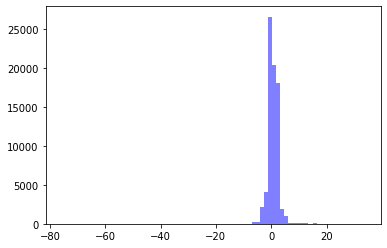

In [69]:
#plot to show how much error we had 
num_bins = 75
n, bins, patches = plt.hist(predictionDif2, num_bins, facecolor='blue', alpha=0.5)
plt.show()


Looking quickly at the graoh above we can see that the model seemed to predict fairly close to 0 error for most of the data, but it seemed to favor predicting high which is shown by a larger portion of the graph being negative. This insight is given to us here but would not be seen when looking strictly at the RMSE.

In [43]:
# Calculate RMSE for our whole number predictions 
predictions2 = predictions2.round()
predictionDif2 = test_labels_2 - predictions2
predictionDifSqr = predictionDif2 ** 2
predictionRME = predictionDifSqr.sum()/predictionDifSqr.count()
predictionRMSE = predictionRME ** 1/2
predictionRME
predictionRMSE

2.283127320143167

It is intresting to see that when we rounded our predictions before computing the difference we actually end up with a higher RMSE. This means that when we are allowing python to round our predictions we are actually more often rounding farther away from the actual. Even though we would want to use our more accurate model on the training data for any further predictions we actually made a much better predicting model than we did in R by using a neural netowrk and giving it a large ammount of data to try to train on. 

Overall I believe that using the neural network model to attempt to predict was succesful and worthwhile. Firstly we were able to reduce the RMSE on test data by 66% but also I was able to get a deeper dive into an intresting prediction method and use it in a way that I had not. Previously I had used neural networks some in another class, but doing this regression taught me how to work with a large dataset, what kind of data pre-procesing needs to be done for a neural network to predict more accuratly, and how much ram is really needed to do this pre-processing and run the models.